<a href="https://colab.research.google.com/github/coderzaman/Machine-Learning/blob/main/Data_Preprocessing_and_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preprocessing and Feature Engineering**

This notebook supports and contains all code and explanatory text for:

- **Part 1**: Missing values, encoding categorical variables, scaling/normalization
- **Part 2**: Outlier detection, feature transformation, domain-driven features,
  preprocessing pipelines, and a quick sanity-check model

Datasets used:
- **Titanic dataset** (from Kaggle) – for demonstrating missing values
- **Heart Failure / Heart Disease dataset** – for the main preprocessing pipeline

Please upload or mount the CSV files in your environment as needed.

---
## Part 1: Core Preprocessing Concepts

In Part 1 we cover:
- Why preprocessing is needed
- How to handle missing values
- How to encode categorical variables
- How to scale / normalize numeric features

###Handling Missing Values (Titanic Dataset)

Real-life analogy: **attendance sheet with blank cells**.

- Some students have `P` (present), some have `A` (absent), and some cells are blank.
- If we ignore those blanks, the final attendance calculation will be wrong.
- We must decide how to handle the blanks using logic.

In the Titanic dataset:
- `Age` has missing values (numeric)
- `Embarked` has a few missing values (categorical)
- `Cabin` has many missing values (often dropped in simple demos)

We will:
1. Inspect missing values
2. Fill numeric column (`Age`) with the **median**
3. Fill categorical column (`Embarked`) with the **mode**
4. Drop `Cabin` because it is mostly missing

### **Import Libray**

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

### **Load Dataset**

In [31]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Dataset/Titanic-Dataset.csv')

# show first 10 dataset from dataset
df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [32]:
df.shape

(891, 12)

In [33]:
# Unique value per column
df.nunique()

,0
PassengerId,891
Survived,2
Pclass,3
Name,891
Sex,2
Age,88
SibSp,7
Parch,7
Ticket,681
Fare,248


In [34]:
print("Missing Value per Column")
df.isna().sum()

Missing Value per Column


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


# **Handling Missing value**

### 📝 Note: Handling Missing Values (মিসিং ভ্যালু হ্যান্ডলিং গাইড)

ডেটা ক্লিনিং করার সময় আমরা সবসময় মিসিং ভ্যালু ফিল (Impute) করি না। আমাদের সিদ্ধান্ত দুটি ধাপে নিতে হয়:

#### ১. ফিচারটি রাখব নাকি বাদ দেব? (Drop vs. Impute)

সব ফিচার গুরুত্বপূর্ণ নয়। যদি কোনো কলামে অতিরিক্ত মাত্রায় তথ্য হারিয়ে যায়, তবে তা রাখা বিপদজনক।

* **নিয়ম:** যদি কোনো ফিচারের **৭০% বা তার বেশি (Threshold > 70%)** ডেটা মিসিং থাকে, তবে সেই ফিচারটি কোনো কাজের তথ্য দেয় না।
* **সিদ্ধান্ত:** সেক্ষেত্রে মিসিং ভ্যালু পূরণ করার চেষ্টা না করে পুরো কলামটি **বাদ দেওয়া (Drop)** বা ডিলিট করে দেওয়াই সবচেয়ে ভালো প্র্যাকটিস।

#### ২. কী দিয়ে ফিল করব? (Imputation Strategy)

যদি মিসিং ভ্যালু কম থাকে (যেমন ১% - ২০%), তবে আমরা সেটি পূরণ করি। পূরণ করার নিয়ম ডেটার ধরণের ওপর নির্ভর করে:

| ডেটার ধরণ (Data Type) | ডেটার প্রকৃতি (Distribution) | কী ব্যবহার করব? | কেন? |
| --- | --- | --- | --- |
| **Numerical** (সংখ্যা) | **Symmetric** (সুষম / No Outlier) | **Mean** (গড়) | সিমেট্রিক ডেটায় গড় মান পুরো ডেটার সঠিক প্রতিনিধিত্ব করে। |
| **Numerical** (সংখ্যা) | **Skewed** (বাঁকানো / Has Outlier) | **Median** (মধ্যক) | আউটলাইয়ার থাকলে গড় (Mean) নষ্ট হয়ে যায়, কিন্তু মিডিয়ান বা মাঝখানের ভ্যালু ঠিক থাকে। এটি নিরাপদ। |
| **Categorical** (টেক্সট) | N/A | **Mode** (প্রচুরক) | টেক্সট ডেটার গড় হয় না। যেই ক্যাটাগরিটি সবচেয়ে বেশিবার আছে (Highest Frequency), সেটি দিয়ে পূরণ করা হয়। |

---

### 💡 কুইক টিপস (Summary)

* **> 70% Missing:** Drop Column ❌
* **Numerical + Symmetric:** Use Mean ✅
* **Numerical + Skewed:** Use Median ✅
* **Categorical:** Use Mode ✅

**Decision: Most of the cabin data is null like more than 70% we will drop cabin column**

Distribution of Age Column



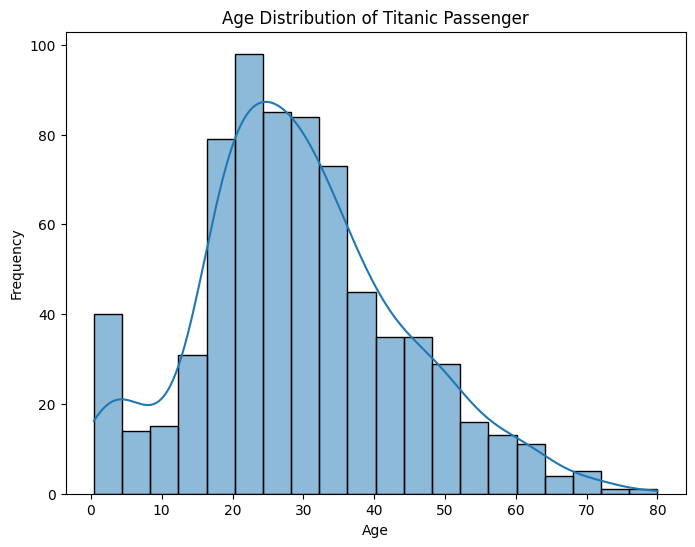

In [35]:
print("Distribution of Age Column\n")

plt.figure(figsize=(8, 6))
sns.histplot(df['Age'], kde=True, bins=20)
plt.title('Age Distribution of Titanic Passenger')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

**Decision: Age is right-skwed data we will replace with it median**

Distribution of Embarked Column



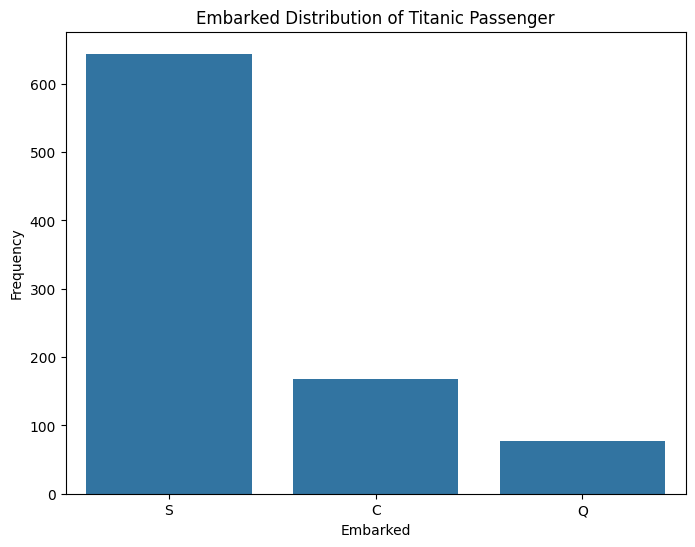

In [36]:
print("Distribution of Embarked Column\n")
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='Embarked')
plt.title('Embarked Distribution of Titanic Passenger')
plt.xlabel('Embarked')
plt.ylabel('Frequency')
plt.show()


**Decision: Here Most of the Embarked value is S, we will repalce with it Mode S**

In [37]:
# 1. Handle numeric missing values: Age
age_median = df['Age'].median()
df["Age"] = df["Age"].fillna(age_median)

# 2. Handle categorical missing values: Embarked
embarked_mode = df["Embarked"].mode()[0]
df["Embarked"] = df["Embarked"].fillna(embarked_mode)

# 3. # 3. Drop Cabin (too many missing values)
df.drop("Cabin", axis=1, inplace=True)

In [38]:
df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


###Encoding Categorical Variables (Heart Dataset)

Real-life analogy: **canteen token system**.

- The canteen menu has items like *Tehari*, *Chowmein*, *Biriyani*.
- The billing machine cannot understand these strings; it needs numeric codes.
- However, assigning `Tehari = 1`, `Chowmein = 2`, `Biriyani = 3` does **not**
  mean Biriyani is greater than Tehari. The numbers are **labels, not ranks**.

In the Heart dataset, we will:
- Use **Label Encoding** for binary categories like `Sex` and `ExerciseAngina`
- Use **OneHot Encoding** for nominal categories like `ChestPainType`,
  `RestingECG`, and `ST_Slope`

In [39]:
from sklearn.preprocessing import LabelEncoder

# Load Heart Dataset
df_heart = pd.read_csv('/content/drive/MyDrive/Dataset/heart.csv')

# first 10 rows
print("First 10 rows of the dataset:")
display(df_heart.head(10))

# Datatype column for which column are categorical
display(df_heart.dtypes)



First 10 rows of the dataset:


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


,0
Age,int64
Sex,object
ChestPainType,object
RestingBP,int64
Cholesterol,int64
FastingBS,int64
RestingECG,object
MaxHR,int64
ExerciseAngina,object
Oldpeak,float64


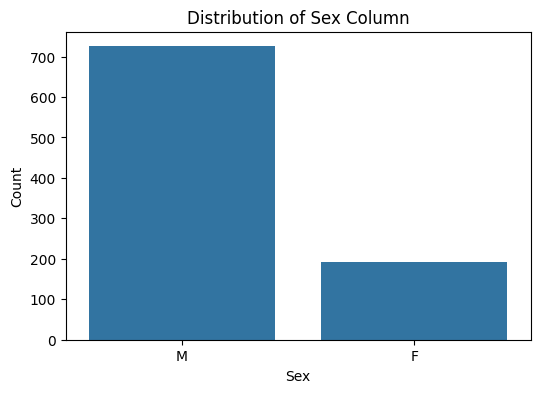

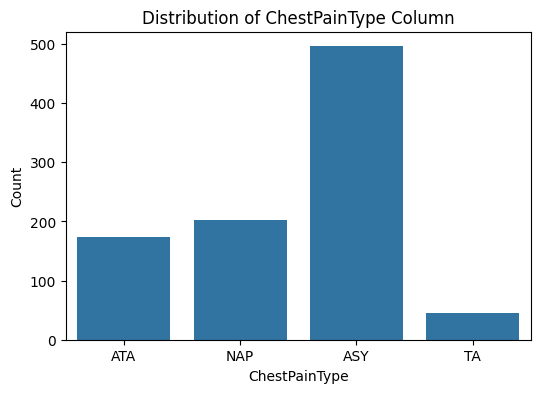

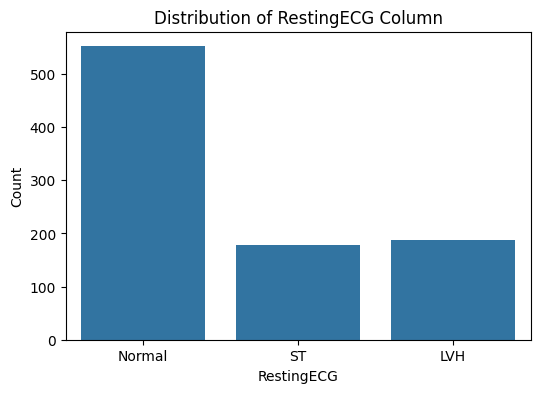

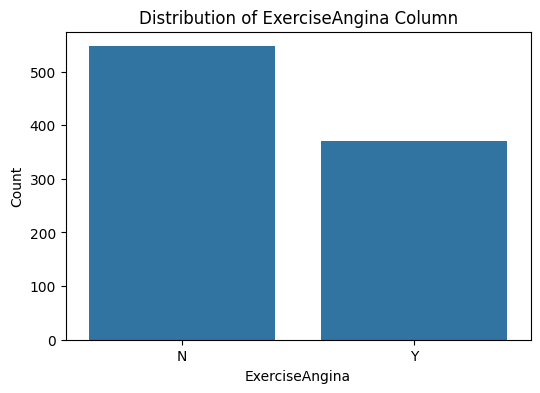

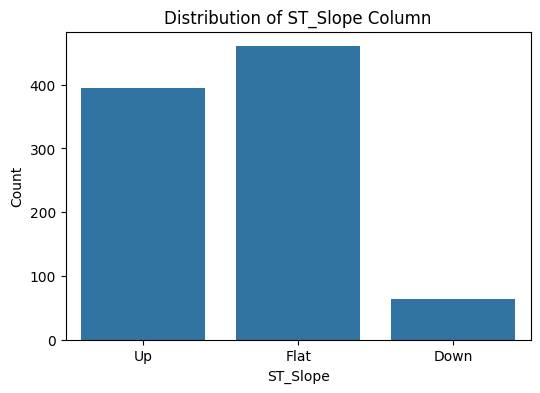

In [40]:
# Categorical Feture Exploration Determine Encoding Types
categorical_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

for c in categorical_cols:
  plt.figure(figsize=(6,4))
  sns.countplot(data=df_heart, x=c)
  plt.title(f"Distribution of {c} Column")
  plt.xlabel(c)
  plt.ylabel("Count")
  plt.show()

### **Decision:**
* Use Label Encoding for binary categories like Sex and ExerciseAngina
* Use OneHot Encoding for nominal categories like ChestPainType,     
 RestingECG, and ST_Slope

In [41]:
# Label Encoding for Binary Categorical Features Sex and ExerciseAngina

le = LabelEncoder()
df_heart["Sex"] = le.fit_transform(df_heart["Sex"])
df_heart["ExerciseAngina"] = le.fit_transform(df_heart["ExerciseAngina"])

display(df_heart.head(10))


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195,0,Normal,122,0,0.0,Up,0
5,39,1,NAP,120,339,0,Normal,170,0,0.0,Up,0
6,45,0,ATA,130,237,0,Normal,170,0,0.0,Up,0
7,54,1,ATA,110,208,0,Normal,142,0,0.0,Up,0
8,37,1,ASY,140,207,0,Normal,130,1,1.5,Flat,1
9,48,0,ATA,120,284,0,Normal,120,0,0.0,Up,0


In [42]:
# One Hot Encoding For Nominal categorical features ChestPainType, RestingECG, and ST_Slope

nominal_categorical_cols = ["ChestPainType", "RestingECG", "ST_Slope"]
df_encoded = pd.get_dummies(df_heart, columns=nominal_categorical_cols, dtype=int)

display(df_encoded.head(10))

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0,0,1,0,0,0,1,0,0,0,1
1,49,0,160,180,0,156,0,1.0,1,0,0,1,0,0,1,0,0,1,0
2,37,1,130,283,0,98,0,0.0,0,0,1,0,0,0,0,1,0,0,1
3,48,0,138,214,0,108,1,1.5,1,1,0,0,0,0,1,0,0,1,0
4,54,1,150,195,0,122,0,0.0,0,0,0,1,0,0,1,0,0,0,1
5,39,1,120,339,0,170,0,0.0,0,0,0,1,0,0,1,0,0,0,1
6,45,0,130,237,0,170,0,0.0,0,0,1,0,0,0,1,0,0,0,1
7,54,1,110,208,0,142,0,0.0,0,0,1,0,0,0,1,0,0,0,1
8,37,1,140,207,0,130,1,1.5,1,1,0,0,0,0,1,0,0,1,0
9,48,0,120,284,0,120,0,0.0,0,0,1,0,0,0,1,0,0,0,1


###Normalization and Scaling

Real-life analogy: **comparing salary and height**.

- Height might range from 150 to 190 cm.
- Salary might range from 20,000 to 700,000.
- If we feed these two features directly into a distance-based model,
  salary will dominate the calculation.

To fix this, we **scale** numeric features so they are on a comparable range.

Common approaches:
- **StandardScaler**: transforms features to have mean 0 and standard deviation 1
- **MinMaxScaler**: rescales features to a fixed range, usually [0, 1]

Always fit the scaler on the **training set only**, then transform both
training and test sets using the same scaler.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

target_col = "HeartDisease"
X = df_encoded.drop(target_col, axis=1)
y = df_encoded[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print("\n--- Displaying Standard Scaled Data ---")
# Convert scaled arrays back to DataFrame for better visualization with column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
print("\nFirst 5 rows of X_train & X_test (Standard Scaled):")
display(X_train_scaled_df.head())
print()
display(X_test_scaled_df.head())



# MinMax Scaling
scaler_mm = MinMaxScaler()
X_train_scaled_mm = scaler_mm.fit_transform(X_train)
X_test_scaled_mm = scaler_mm.transform(X_test)

print("\n--- Displaying MinMax Scaled Data ---")
# Convert scaled arrays back to DataFrame for better visualization with column names
X_train_scaled_df = pd.DataFrame(X_train_scaled_mm, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled_mm, columns=X_test.columns, index=X_test.index)
print("\nFirst 5 rows of X_train & X_test (MinMax Normalization):")
display(X_train_scaled_df.head())
print()
display(X_test_scaled_df.head())


--- Displaying Standard Scaled Data ---

First 5 rows of X_train & X_test (Standard Scaled):


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
795,-1.245067,0.540605,-0.708985,0.372803,1.842609,2.284353,-0.838461,-0.097061,-1.097362,-0.483336,1.879059,-0.213504,-0.504679,0.808179,-0.487621,3.780432,-1.03325,-0.847921
25,-1.886236,0.540605,-0.166285,0.086146,-0.542709,1.652241,-0.838461,-0.836286,-1.097362,-0.483336,1.879059,-0.213504,-0.504679,0.808179,-0.487621,-0.264520,-1.03325,1.179356
84,0.250993,0.540605,0.919115,0.123134,1.842609,-0.441628,1.192662,0.087745,0.911276,-0.483336,-0.532181,-0.213504,-0.504679,0.808179,-0.487621,-0.264520,0.96782,-0.847921
10,-1.779375,-1.849780,-0.166285,0.104640,-0.542709,0.229991,-0.838461,-0.836286,-1.097362,-0.483336,1.879059,-0.213504,-0.504679,0.808179,-0.487621,-0.264520,-1.03325,1.179356
344,-0.283314,0.540605,-0.708985,-1.846478,1.842609,-1.271274,-0.838461,-0.836286,0.911276,-0.483336,-0.532181,-0.213504,-0.504679,0.808179,-0.487621,-0.264520,0.96782,-0.847921


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
668,0.999024,-1.849780,0.376415,-0.043312,-0.542709,1.691748,-0.838461,-0.836286,-1.097362,2.068955,-0.532181,-0.213504,-0.504679,0.808179,-0.487621,-0.26452,-1.03325,1.179356
30,-0.069591,0.540605,0.647765,2.943471,-0.542709,-0.244093,-0.838461,-0.836286,-1.097362,-0.483336,1.879059,-0.213504,-0.504679,0.808179,-0.487621,-0.26452,0.96782,-0.847921
377,1.212747,0.540605,1.461816,-1.846478,1.842609,-0.560148,-0.838461,0.272552,0.911276,-0.483336,-0.532181,-0.213504,-0.504679,-1.237350,2.050774,-0.26452,0.96782,-0.847921
535,0.250993,0.540605,-0.166285,-1.846478,-0.542709,-0.560148,1.192662,0.087745,0.911276,-0.483336,-0.532181,-0.213504,1.981458,-1.237350,-0.487621,-0.26452,0.96782,-0.847921
807,0.037270,0.540605,-1.360226,1.010846,-0.542709,0.783088,-0.838461,-0.836286,-1.097362,2.068955,-0.532181,-0.213504,-0.504679,0.808179,-0.487621,-0.26452,-1.03325,1.179356



--- Displaying MinMax Scaled Data ---

First 5 rows of X_train & X_test (MinMax Normalization):


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
795,0.270833,1.0,0.60,0.398010,1.0,0.943662,0.0,0.386364,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
25,0.145833,1.0,0.65,0.346600,0.0,0.830986,0.0,0.295455,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
84,0.562500,1.0,0.75,0.353234,1.0,0.457746,1.0,0.409091,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
10,0.166667,0.0,0.65,0.349917,0.0,0.577465,0.0,0.295455,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
344,0.458333,1.0,0.60,0.000000,1.0,0.309859,0.0,0.295455,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
668,0.708333,0.0,0.700,0.323383,0.0,0.838028,0.0,0.295455,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
30,0.500000,1.0,0.725,0.859038,0.0,0.492958,0.0,0.295455,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
377,0.750000,1.0,0.800,0.000000,1.0,0.436620,0.0,0.431818,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
535,0.562500,1.0,0.650,0.000000,0.0,0.436620,1.0,0.409091,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
807,0.520833,1.0,0.540,0.512438,0.0,0.676056,0.0,0.295455,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### ১. লাইন বাই লাইন ব্যাখ্যা (Line by Line Explanation)

1. **`from sklearn... import ...`**: প্রয়োজনীয় টুলবক্স বা লাইব্রেরি ইমপোর্ট করা হচ্ছে। `StandardScaler` ডেটার স্কেল ঠিক করার জন্য আনা হয়েছে।
2. **`target_col = "HeartDisease"`**: আমরা কাকে প্রেডিক্ট করতে চাই (Target), তার নাম ঠিক করে রাখলাম।
3. **`X = df...drop(...)`**: পুরো ডেটাসেট থেকে উত্তরের কলামটি (`HeartDisease`) ফেলে দিয়ে বাকি সব ইনপুট ফিচার `X`-এ রাখা হলো।
4. **`y = df...[target_col]`**: শুধু উত্তরের কলামটি `y`-এ রাখা হলো।
5. **`train_test_split(...)`**:
* পুরো ডেটাকে দুই ভাগে ভাগ করা হলো: **৮০% ট্রেনিং** (মডেল শিখবে) এবং **২০% টেস্টিং** (মডেল পরীক্ষা হবে)।
* `random_state=42`: প্রতিবার রান করলে যেন ডেটা একইভাবে ভাগ হয়, এলোমেলো না হয়।


6. **`scaler = StandardScaler()`**: স্কেলার বা "পরিমাপক যন্ত্র" টি তৈরি করা হলো। কিন্তু এটি এখনো কিছু শিখেনি (Empty)।
7. **`X_train_scaled = scaler.fit_transform(X_train)`**: **(সবচেয়ে গুরুত্বপূর্ণ)** স্কেলারটি ট্রেনিং ডেটা থেকে শিখল (fit) এবং ডেটাকে পরিবর্তন (transform) করল।
8. **`X_test_scaled = scaler.transform(X_test)`**: স্কেলারটি টেস্ট ডেটাকে শুধু পরিবর্তন করল, নতুন করে কিছু শিখল না।
9. **`pd.DataFrame(...)`**: স্কেলিং করার পর ডেটাগুলো `numpy array` (শুধু সংখ্যা) হয়ে যায়, কলামের নাম হারিয়ে যায়। তাই দেখার সুবিধার্থে সেগুলোকে আবার সুন্দর টেবিলে (DataFrame) রূপান্তর করা হলো।

---

### ২. `fit_transform` বনাম `transform` এর পার্থক্য (The Main Concept)

মেশিন লার্নিংয়ে এটি একটি ইন্টারভিউ প্রশ্ন। খুব মনোযোগ দিয়ে বুঝুন:

`StandardScaler` মূলত এই সূত্র ব্যবহার করে: Z = \frac{x - \mu}{\sigma}

* \mu (Mean) = গড় মান
* \sigma (Std Dev) = বিচ্যুতি বা ডেটা কতটা ছড়ানো।

#### ক. Train ডেটায় `fit_transform` কেন?

* **`fit` (শেখা):** এটি প্রথমে `X_train` এর **গড় (Mean)** এবং **স্ট্যান্ডার্ড ডেভিয়েশন (Std)** ক্যালকুলেট করে মেমোরিতে সেভ করে রাখে। একেই বলা হয় "মডেল ফিট করা"।
* **`transform` (প্রয়োগ):** এরপর সেই সেভ করা গড় এবং Std ব্যবহার করে ডেটাটিকে কনভার্ট করে।
* এক কথায় `fit_transform` = **শেখা + প্রয়োগ করা।**

#### খ. Test ডেটায় শুধুই `transform` কেন?

* এখানে আমরা `fit` করি না। আমরা শুধু **`transform`** করি।
* এর মানে হলো: টেস্ট ডেটা কনভার্ট করার সময় আমরা **ট্রেনিং ডেটার** গড় এবং Std ব্যবহার করি। টেস্ট ডেটার নিজস্ব গড় বা Std বের করি না।

### ৩. কেন টেস্ট ডেটায় `fit` করা যাবে না? (Why strictly restricted?)

এর প্রধান কারণ হলো **Data Leakage (তথ্য ফাঁস)**।

১. **বাস্তব জীবনের লজিক:**
মডেল যখন বাস্তবে কাজ করবে, তখন তার কাছে ভবিষ্যতের ডেটা থাকবে না। তাই সে ভবিষ্যতের ডেটার "গড়" জানবে না। তাকে তার ছোটবেলার শেখা (Training data) জ্ঞান দিয়েই নতুন ডেটাকে বিচার করতে হবে।

২. **পরীক্ষার উদাহরণ (Analogy):**

* **Train Set:** পাঠ্যবই (Syllabus)।
* **Test Set:** ফাইনাল পরীক্ষার প্রশ্ন।
* **Fit_transform (Train):** আপনি পাঠ্যবই পড়ে জ্ঞান অর্জন করলেন (Fit) এবং নিজেকে প্রস্তুত করলেন (Transform)।
* **Transform (Test):** পরীক্ষার হলে আপনি আপনার অর্জিত জ্ঞান (Training Knowledge) ব্যবহার করে উত্তর দেবেন।
* **ভুল পদ্ধতি (Fit on Test):** যদি আপনি পরীক্ষার প্রশ্ন দেখে সেই অনুযায়ী নতুন করে পড়াশোনা শুরু করেন, তবে সেটা হবে **"নকল করা" বা Cheating**। মেশিন লার্নিংয়ে টেস্ট ডেটায় `fit` করা মানেই পরীক্ষার প্রশ্ন আগে দেখে ফেলা।

**সারসংক্ষেপ:**

* **Train Data:** `fit_transform()` \rightarrow রুলস শিখব এবং অ্যাপ্লাই করব।
* **Test Data:** `transform()` \rightarrow আগের শেখা রুলস দিয়েই অ্যাপ্লাই করব (নতুন কিছু শিখব না)।

`StandardScaler` বা যেকোনো স্কেলার ব্যবহার করার পর ডেটা আর **DataFrame** থাকে না, সেটি **NumPy Array** (শুধু সংখ্যার ম্যাট্রিক্স) হয়ে যায়। এর ফলে কলামের নাম (Column Names) এবং ইনডেক্স নম্বর (Index/Row ID) হারিয়ে যায়।

সেগুলোকে ফিরিয়ে আনার জন্যই এই লাইনটি লেখা হয়েছে। নিচে প্রতিটি প্যারামিটার আলাদা করে বুঝিয়ে বলছি:

```python
pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

```

### ১. `X_train_scaled` (প্রথম প্যারামিটার: ডেটা)

এটি হলো **ডেটার মূল বডি** বা কন্টেন্ট।

* স্কেলার (`scaler.fit_transform`) আমাদের যে আউটপুট দিয়েছে, সেটি একটি প্লেইন ম্যাট্রিক্স। সেখানে কোনো হেডার নেই, কোনো আইডি নেই, শুধুই `[[0.5, -1.2], [1.1, 0.3]...]` এমন সংখ্যা।
* এই অংশটি বলছে: "টেবিলের ভেতরে এই ভ্যালুগুলো বসাও।"

### ২. `columns=X_train.columns` (কলামের নাম ফেরত আনা)

NumPy Array তে কোনো কলামের নাম (যেমন: 'Age', 'Cholesterol') থাকে না, শুধু 0, 1, 2... থাকে।

* **সমস্যা:** কলামের নাম না থাকলে আপনি বুঝতে পারবেন না কোন সংখ্যাটা বয়সের আর কোনটা কোলেস্টেরলের।
* **সমাধান:** যেহেতু `X_train` (অরিজিনাল ডেটা)-তে নামগুলো ঠিকঠাক ছিল, তাই আমরা বলছি— *"অরিজিনাল ডেটা থেকে নামগুলো কপি করে এই নতুন টেবিলে বসিয়ে দাও।"*

### ৩. `index=X_train.index` (সবচেয়ে গুরুত্বপূর্ণ: রোল নম্বর ঠিক রাখা)

এটি অনেকেই মিস করে, কিন্তু এটি খুবই জরুরি।

* **ঘটনা:** `train_test_split` করার সময় ডেটা **এলোমেলো (Shuffle)** হয়ে যায়। ধরুন, প্রথম রো-এর আইডি ছিল ১০, দ্বিতীয়টির ৫, তৃতীয়টির ৮৯।
* **সমস্যা:** যদি আপনি `index` প্যারামিটার না দেন, পান্ডাস অটোমেটিক্যালি নতুন করে `0, 1, 2, 3...` ইনডেক্স বসিয়ে দেবে। ফলে আসল ডেটার সাথে (বা `y_train` এর সাথে) এর লিংক বা সিরিয়াল নম্বর আর মিলবে না।
* **সমাধান:** `index=X_train.index` বলে দেয়— *"অরিজিনাল ডেটায় যে রো-এর আইডি যা ছিল (যেমন ১০, ৫, ৮৯), এখানেও ঠিক সেই আইডিই বসাও।"*

### এক নজরে সারসংক্ষেপ:

| প্যারামিটার | কাজ | সহজ কথায় |
| --- | --- | --- |
| **Data** (`X_train_scaled`) | ভেতরের মালমসলা | শুধু সংখ্যাগুলো (Values)। |
| **Columns** | উপরের শিরোনাম | কোন কলামের নাম কী (Age, Salary...)। |
| **Index** | বাম পাশের সিরিয়াল | কোন রো-টা কার (Patient ID বা Row ID)। |

**ফলাফল:** এই লাইনটি চালানোর পর আপনি আবার আগের মতো সুন্দর সাজানো টেবিল ফেরত পাবেন, যেখানে স্কেল করা ভ্যালুগুলো থাকবে।